In [16]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.special as spec
import scipy.integrate as integrate
import scipy.optimize as opt
import matplotlib.animation as anime
#data array

#burrell data
Experimental = np.array(
                #burrell
                [('burrell', 'C40+ optical', 99.99, 145, 1.168, 1), ('benhelm', 'C40+ optical', 99.925, 3000, 1.168, 1), ('myerson', 'C40+ optical', 99.991, 145, 1.168, 1),],

            #fidelity the average is for the two states (burrell)
            dtype=[('author', np.string_), ('ion', np.string_), ('fidelity', 'float'), ('readout time(us)', 'float'), ('coherence T1(s)', 'U8'), ('coherence T2(ms)','U8')])

print(Experimental)

[(b'', b'', 99.99 ,  145., '1.168', '1')
 (b'', b'', 99.925, 3000., '1.168', '1')
 (b'', b'', 99.991,  145., '1.168', '1')]


In [17]:
'''In general, the rates for pumping between the qubit states will not be zero. For the
calcium optical qubit the |B〉→|D〉 pumping rate remains negligible (section 4.3.3), but
the rate of |D〉→|B〉pumping due to decay from the metastable D5/2 state is appreciable
at 1/τ where τ = 1.168(7) s is the average lifetime of the shelf state [138].
The count distribution B0(n) for trials prepared in the |B〉 state remains Poisson 
distributed with mean (RB + RD)tb, but the distribution for trials initially prepared in
the |D〉 state is modified to contain two terms:'''

'In general, the rates for pumping between the qubit states will not be zero. For the\ncalcium optical qubit the |B〉→|D〉 pumping rate remains negligible (section 4.3.3), but\nthe rate of |D〉→|B〉pumping due to decay from the metastable D5/2 state is appreciable\nat 1/τ where τ = 1.168(7) s is the average lifetime of the shelf state [138].\nThe count distribution B0(n) for trials prepared in the |B〉 state remains Poisson \ndistributed with mean (RB + RD)tb, but the distribution for trials initially prepared in\nthe |D〉 state is modified to contain two terms:'

In [18]:
'''The number of counts n recorded in tb when an ion decays at a time t is Poisson distributed with mean λ(t)'''

#functions

def Bmean(RB, RD, tb):
    x = (RB+RD)*tb
    return x

def Dmean(RD, tb):
    x = RD*tb
    return x

def Bo(N, Bmean):
    x = (np.power(Bmean,N)) * (np.exp(Bmean)) / spec.factorial(N)
    return x    

def Do(N, Dmean,RB,RD,tb,tau):
    x = (np.e**(-tb/tau) * ((Dmean)**N) * (np.exp(Dmean)) / spec.factorial(N)) + Xo(N,RB,RD,tb,tau)
    return x

def Xo(N,RB,RD,tb,tau):
    X0 = []
    for n in N:
        X0 = np.append(X0, (integrate.quad(X_integrand, RD*tb, (RB+RD)*tb, args=(n,RB,RD,tau,tb)))[0])
    print(X0)
    return X0

def X_integrand(l,n,RB,RD,tau,tb):
    return (1/(RB*tau))*np.exp((l-((RD+RB)*tb))/(RB*tau))*np.power(l,n)*np.exp(-l)/spec.factorial(n)


[1.27503729e-05 1.28058644e-05 1.28603218e-05 ... 1.10625419e-11
 1.09750572e-11 1.08882441e-11]
0.0


Text(0.5, 1.0, 'Count Probability with |D> to |B> Due to Decay at Bin Time 0.00042s')

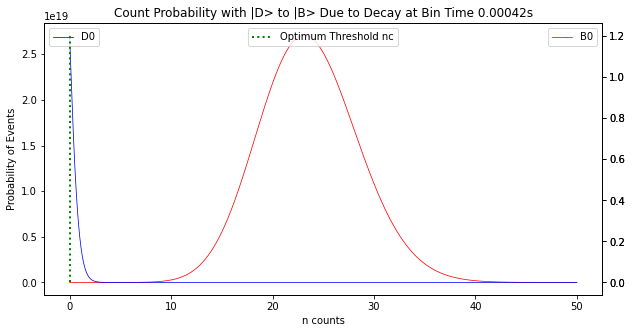

In [19]:
#Variables

#Burrell quoted
#RB = 55800 s−1
#RD = 442 s−1
#tb = 420 us = .00042

#nc = diferentiation counts

#n = counts
nMax = 50
#Bright state fluoresence rate
Rb = 55800
#Dark state fluoresence rate
Rd = 442
#bin time
tb = .00042
#tau decay time for Ca40
tau = 1.167

step = .01
N = np.arange(start=0,stop=nMax,step=step)

#Graphing
Bmean = Bmean(Rb,Rd,tb)
BM = np.full(np.int_(nMax/step),Bmean)
Dmean = Dmean(Rd,tb)

#n counts in tb from bright
B0 = Bo(N,BM)
#print(N)
#print(B0)
#n counts in tb from dark
D0 = Do(N,Dmean,Rb,Rd,tb,tau)

#B0 = B0/np.sum(B0)
#D0 = D0/np.sum(D0)
#count threshold
nc = 0
minDiff = np.abs(B0[0]-D0[0])
for i, item in enumerate(B0):
    diff = np.abs(B0[i]-D0[i])
    #print(diff)
    if(diff<minDiff):
        nc = i
        minDiff = diff
nc=nc*step
print(nc)

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(N, B0, lw=0.75, c="r", label = "B0")
ax1.set_ylabel("Number of Events")
ax1.set_xlabel("n counts")
ax2 = plt.twinx(ax1)
ax2.plot(N, D0, lw=0.75, c="b", label = "D0")
ax3 = plt.twinx(ax1)
plt.vlines(nc, ymin=0, ymax=np.max(D0), colors='green', ls=':', lw=2, label='Optimum Threshold nc')
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper left')
ax3.legend(loc = 'upper center')
plt.title("Count Probability with |D> to |B> Due to Decay at Bin Time "+ str(tb)+"s")

In [20]:
#Optimal Time vs Collection Efficiency

#Find error at a specific bin time and n count

Rb = 55800
Rd = 442
#bin time
tb = .00042
#optimal count nc
n = nc
tau = 1.168 #s for Ca40


#integrate D for n's @tb
def ed(tb): 
    return integrate.quad(D_integrand, nc, np.inf, args=(Rd,Rb,tb,tau))

def D_integrand(n,Rd,Rb,tb,tau):
    return ((np.e**(-tb/tau)*((Dmean)**n)*(np.exp(Dmean)) / spec.factorial(n)) + (integrate.quad(X_integrand, Rd*tb, (Rb+Rd)*tb, args=(n,Rb,Rd,tau,tb)))[0])

#integrate X for lambda's
def X_integrand(l,n,Rb,Rd,tau,tb):
    return (1/(Rb*tau))*np.exp((l-((Rd+Rb)*tb))/(Rb*tau))*np.power(l,n)*np.exp(-l)/spec.factorial(n)
    
#0 to nc w/ B0
def eb(tb):
    return integrate.quad(B_integrand, 0, nc, args=(Rb, Rd, tb))

def B_integrand(n, Rb, Rd, tb):
    return (np.power((Rb+Rd)*tb,n)) * (np.exp((Rb+Rd)*tb)) / spec.factorial(n)



print(ed(tb))
print(eb(tb))

'''
tb = np.arange(start=0,stop=tb,step=.00001)
#print(tb)

darkE = np.empty(0)
brightE = np.empty(0)



for i in tb:
    darkE = np.append(darkE, ed(i)[0])
for i in tb:
    brightE = np.append(brightE, eb(i)[0])

#print(darkE)

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(tb, darkE, lw=0.75, c="r", label = "D0")
ax1.set_ylabel("Error")
ax1.set_xlabel("Bin Time (s)")
ax2 = plt.twinx(ax1)
ax2.plot(tb, brightE, lw=0.75, c="b", label = "B0")
ax1.legend(loc = 'upper center')
ax2.legend(loc = 'upper left')

plt.title("Dark and Bright Errors Finite Lifetime ")
'''

(nan, nan)
(0.0, 0.0)


C:\Users\SALAMA~1\AppData\Local\Temp/ipykernel_9212/3892244636.py:23: RuntimeWarning: overflow encountered in power
  return (1/(Rb*tau))*np.exp((l-((Rd+Rb)*tb))/(Rb*tau))*np.power(l,n)*np.exp(-l)/spec.factorial(n)
C:\Users\SALAMA~1\AppData\Local\Temp/ipykernel_9212/3892244636.py:23: RuntimeWarning: invalid value encountered in double_scalars
  return (1/(Rb*tau))*np.exp((l-((Rd+Rb)*tb))/(Rb*tau))*np.power(l,n)*np.exp(-l)/spec.factorial(n)
C:\Users\SALAMA~1\AppData\Local\Temp/ipykernel_9212/3892244636.py:19: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return ((np.e**(-tb/tau)*((

'\ntb = np.arange(start=0,stop=tb,step=.00001)\n#print(tb)\n\ndarkE = np.empty(0)\nbrightE = np.empty(0)\n\n\n\nfor i in tb:\n    darkE = np.append(darkE, ed(i)[0])\nfor i in tb:\n    brightE = np.append(brightE, eb(i)[0])\n\n#print(darkE)\n\nfig = plt.figure(figsize=(10, 5))\nax1 = fig.add_subplot(1, 1, 1)\nax1.plot(tb, darkE, lw=0.75, c="r", label = "D0")\nax1.set_ylabel("Error")\nax1.set_xlabel("Bin Time (s)")\nax2 = plt.twinx(ax1)\nax2.plot(tb, brightE, lw=0.75, c="b", label = "B0")\nax1.legend(loc = \'upper center\')\nax2.legend(loc = \'upper left\')\n\nplt.title("Dark and Bright Errors Finite Lifetime ")\n'